In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import stats

%matplotlib inline

import seaborn as sns
import random
import csv
import re
import pickle
from tqdm import tqdm
from natsort import natsorted

In [2]:
DATADIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/data')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')

In [3]:
def walkdir(folder):
    for item in os.scandir(folder):
        if item.is_dir():
            yield from walkdir(item.path)
        else:
            path_split = item.path.split('/')
            file = path_split[-1]
            folder = '/'.join(path_split[:-1])
            yield file, folder

In [4]:
train_files_map = {}
for item in walkdir(os.path.join(DATADIR, 'train')):
    file, folder = item
    re_img_file = re.search(r'^(\d+)_(\d+).tif$', file)
    re_mask_file = re.search(r'^(\d+)_(\d+)_mask.tif$', file)
    filetype = ''
    if re_img_file is not None:
        subject = re_img_file.group(1)
        img = re_img_file.group(2)
        filetype = 'img'
    elif re_mask_file is not None:
        subject = re_mask_file.group(1)
        img = re_mask_file.group(2)
        filetype = 'mask'
    else:
        continue
    key = '{}_{}'.format(subject, img)
    if key not in train_files_map:
        if filetype == 'img':
            train_files_map[key] = {'img_file': file, 'folder': folder, 'subject': subject, 'img': img}
        elif filetype == 'mask':
            train_files_map[key] = {'mask_file': file, 'folder': folder, 'subject': subject, 'img': img}
    else:
        if filetype == 'img':
            train_files_map[key]['img_file'] = file
        elif filetype == 'mask':
            train_files_map[key]['mask_file'] = file
                
test_files_map = {}
for item in walkdir(os.path.join(DATADIR, 'test')):
    file, folder = item
    re_img_file = re.search(r'^(\d+).tif$', file)
    if re_img_file is not None:
        img = re_img_file.group(1)
    else:
        continue
    key = img
    if key not in test_files_map:
        test_files_map[key] = {'img_file': file, 'folder': folder, 'img': img}
    else:
        test_files_map[key]['img_file'] = file

In [5]:
list(train_files_map.values())[0]

{'folder': '/home/leon/ml/kaggle/ultrasound-nerve-segmentation/data/train',
 'img': '120',
 'img_file': '1_120.tif',
 'mask_file': '1_120_mask.tif',
 'subject': '1'}

In [6]:
list(test_files_map.values())[0]

{'folder': '/home/leon/ml/kaggle/ultrasound-nerve-segmentation/data/test',
 'img': '2126',
 'img_file': '2126.tif'}

In [7]:
# rle = run-length encoded
train_masks = {}
with open(os.path.join(DATADIR, 'train_masks.csv'), 'r') as f:
    for i, row in enumerate(csv.reader(f)):
        if i > 0:
            subject, img, pixels_rle = row
            train_masks['{}_{}'.format(subject, img)] = pixels_rle

In [8]:
def to_rle(mask):
    """
    Convert mask (as 2-D numpy array) to run-length encoding
    """
    rle = ''
    y_pos, x_pos = np.where(mask == 1)
    pixel_nums = []
    for i in range(y_pos.shape[0]):
        pixel_nums.append(x_pos[i] * mask.shape[0] + y_pos[i] + 1)
    pixel_nums_sorted = sorted(pixel_nums)
    run_start = np.where(np.diff(pixel_nums_sorted) != 1)[0] + 1
    if len(pixel_nums_sorted) > 0:
        run_start = np.concatenate(([0], run_start))
    run_length = np.diff(run_start)
    if len(pixel_nums_sorted) > 0:
        run_length = np.concatenate((run_length, [len(pixel_nums_sorted) - run_start[-1]]))
    if run_start.shape[0] != run_length.shape[0]:
        raise Exception('run_start and run_length do not have the same length.')

    if run_start.shape[0] > 0:
        rle += '{} {}'.format(pixel_nums_sorted[run_start[0]], run_length[0])
    for i in range(1, run_start.shape[0]):
        rle += ' {} {}'.format(pixel_nums_sorted[run_start[i]], run_length[i])
    return rle

subject: 14, img: 70
to_rle function outputs same encoding as provided: True


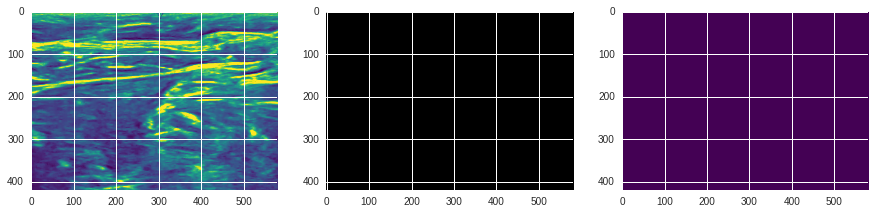

In [9]:
rand_i = random.randint(0, len(train_files_map) - 1)
file_info = list(train_files_map.values())[rand_i]
img_filepath = os.path.join(file_info['folder'], file_info['img_file'])
mask_filepath = os.path.join(file_info['folder'], file_info['mask_file'])

plt.figure(figsize=(15,5))
image = io.imread(img_filepath) / 255.0
mask = io.imread(mask_filepath) / 255.0
print('subject: {}, img: {}'.format(file_info['subject'], file_info['img']))
plt.subplot(1,3,1)
plt.imshow(image, cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.imshow(mask * image, cmap=plt.cm.viridis)

print('to_rle function outputs same encoding as provided:',
      to_rle(mask) == train_masks['{}_{}'.format(file_info['subject'], file_info['img'])])

subject: 18, img: 2
presence label: True


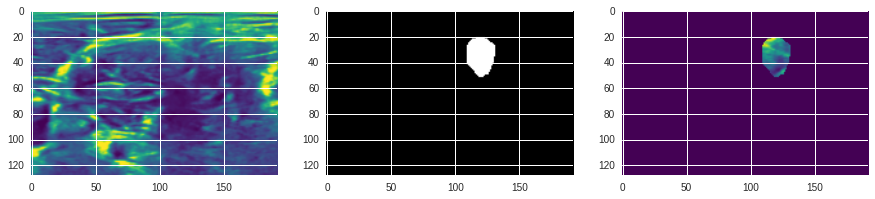

In [17]:
orig_img_rows, orig_img_cols = 420, 580
img_rows, img_cols = 128, 192

rand_i = random.randint(0, len(train_files_map) - 1)
file_info = list(train_files_map.values())[rand_i]
img_filepath = os.path.join(file_info['folder'], file_info['img_file'])
mask_filepath = os.path.join(file_info['folder'], file_info['mask_file'])

plt.figure(figsize=(15,5))
image = imresize(io.imread(img_filepath), size=(img_rows, img_cols), interp='bilinear') / 255.0
mask = imresize(io.imread(mask_filepath), size=(img_rows, img_cols), interp='nearest').astype(np.bool)
print('subject: {}, img: {}'.format(file_info['subject'], file_info['img']))

if np.sum(mask) == 0:
    presence = False
else:
    presence = True
print('presence label:', presence)

plt.subplot(1,3,1)
plt.imshow(image, cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.imshow(mask * image, cmap=plt.cm.viridis)

In [9]:
def get_centroid(mask):
    try:
        xcoords, ycoords = np.where(np.diff(mask) != 0)
        centroid_x = np.min(xcoords) + ((np.max(xcoords) - np.min(xcoords)) / 2)
        centroid_y = np.min(ycoords) + ((np.max(ycoords) - np.min(ycoords)) / 2)
        return centroid_x, centroid_y
    except:
        return 0, 0

In [ ]:
#xcoords, ycoords = np.where(np.diff(mask) != 0)
#print((np.max(xcoords) - np.min(xcoords)), (np.max(ycoords) - np.min(ycoords)))
print(get_centroid(mask))

In [11]:
heights = []
widths = []
for i in tqdm(range(len(train_files_map))):
    file_info = list(train_files_map.values())[i]
    mask_filepath = os.path.join(file_info['folder'], file_info['mask_file'])
    mask = io.imread(mask_filepath)
    xcoords, ycoords = np.where(np.diff(mask) != 0)
    if len(xcoords) > 0:
        heights.append(np.max(xcoords) - np.min(xcoords))
    if len(ycoords) > 0:
        widths.append(np.max(ycoords) - np.min(ycoords))
print(stats.describe(heights))
print(stats.describe(widths))

  3%|▎         | 150/5635 [00:00<00:18, 298.39it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5635/5635 [00:09<00:00, 564.21it/s]

DescribeResult(nobs=2323, minmax=(48, 211), mean=116.82823934567369, variance=354.62207902623766, skewness=0.655070024319945, kurtosis=1.3665600925430414)
DescribeResult(nobs=2323, minmax=(45, 354), mean=92.436504520017223, variance=668.89809837067298, skewness=1.6282462847491113, kurtosis=6.719157430377191)


  0%|          | 0/5635 [00:00<?, ?it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5635/5635 [00:04<00:00, 1289.47it/s]


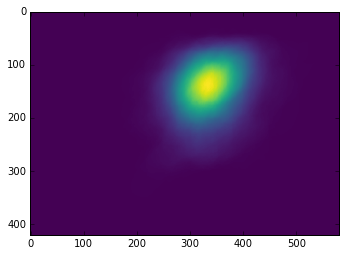

In [10]:
mask_aggregate = []
for i in tqdm(range(len(train_files_map))):
    file_info = list(train_files_map.values())[i]
    mask_filepath = os.path.join(file_info['folder'], file_info['mask_file'])
    mask = io.imread(mask_filepath)
    mask_aggregate.append(mask)
mask_aggregate = np.mean(np.array(mask_aggregate, dtype=np.float32), axis=0)
plt.imshow(mask_aggregate, cmap=plt.cm.viridis)

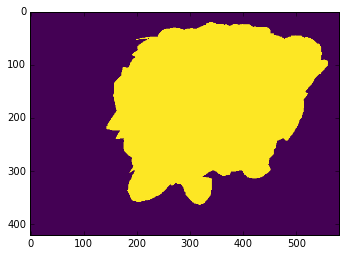

In [21]:
plt.imshow(mask_aggregate > 0.05, cmap=plt.cm.viridis)

## detecting inconsistent labels

In [50]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype('float') - imageB.astype('float')) ** 2, dtype='float64')
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

keys_sorted = natsorted(list(train_files_map.keys()))

images = []
masks = []
for key in tqdm(keys_sorted):
    file_info = train_files_map[key]
    img_filepath = os.path.join(file_info['folder'], file_info['img_file'])
    mask_filepath = os.path.join(file_info['folder'], file_info['mask_file'])
    image = imresize(io.imread(img_filepath), size=(64,64), interp='bilinear') / 255.0
    mask = imresize(io.imread(mask_filepath), size=(64,64), interp='bilinear').astype(np.bool)
    images.append(image)
    masks.append(mask)

images_mse_corr = np.ones((len(images), len(images)))
masks_diff = np.zeros((len(images), len(images)))
for i in tqdm(range(len(images))):
    for j in range(i+1, len(images)):
        image_A, image_B = images[i], images[j]
        mask_A, mask_B = masks[i], masks[j]
        images_mse_corr[i,j] = mse(image_A, image_B)
        images_mse_corr[j,i] = mse(image_A, image_B)
        masks_diff[i,j] = np.abs(np.sum(mask_A, dtype='float64') - np.sum(mask_B, dtype='float64'))
        masks_diff[j,i] = np.abs(np.sum(mask_A, dtype='float64') - np.sum(mask_B, dtype='float64'))

  1%|          | 41/5635 [00:00<01:50, 50.78it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5635/5635 [21:35<00:00,  4.35it/s] 


In [51]:
stats.describe(images_mse_corr.ravel())

DescribeResult(nobs=31753225, minmax=(0.0, 1.0), mean=0.05634443358253257, variance=0.00028998087457869539, skewness=30.31785390703259, kurtosis=1671.3711094093726)

In [52]:
stats.describe(masks_diff.ravel())

DescribeResult(nobs=31753225, minmax=(0.0, 371.0), mean=88.441888973482222, variance=7023.6172311528871, skewness=0.24647049884785094, kurtosis=-1.408946705621296)

In [69]:
# almost identical images, but conflicting presence of masks
questionable_combos = []

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        if images_mse_corr[i, j] < 0.01 and masks_diff[i, j] > 90:
            questionable_combos.append((i, j))
            
print('number:', len(questionable_combos))

number: 4073


In [21]:
mask_none_indices = frozenset([i for i in tqdm(range(len(images))) if np.sum(masks[i], dtype='float') == 0])
mask_present_indices = frozenset([i for i in range(len(images)) if i not in mask_none_indices])

conflicting = {}
for i in tqdm(mask_none_indices):
    image_A = images[i]
    mask_A = masks[i]
    for j in mask_present_indices:
        image_B = images[j]
        mask_B = masks[j]
        images_mse = mse(image_A, image_B)
        if images_mse < 0.01:
            if i in conflicting:
                conflicting[i].append(j)
            else:
                conflicting[i] = [j]
                        
print('number:', len(conflicting))

100%|██████████| 3312/3312 [02:59<00:00, 18.25it/s]

number: 1154


In [22]:
stats.describe([len(conflict_arr) for conflict_arr in conflicting.values()])

DescribeResult(nobs=1154, minmax=(1, 22), mean=3.430675909878683, variance=14.772726862784296, skewness=2.5550747382073262, kurtosis=7.172695367227664)

2176 (19_20.tif), 2188 (19_32.tif)


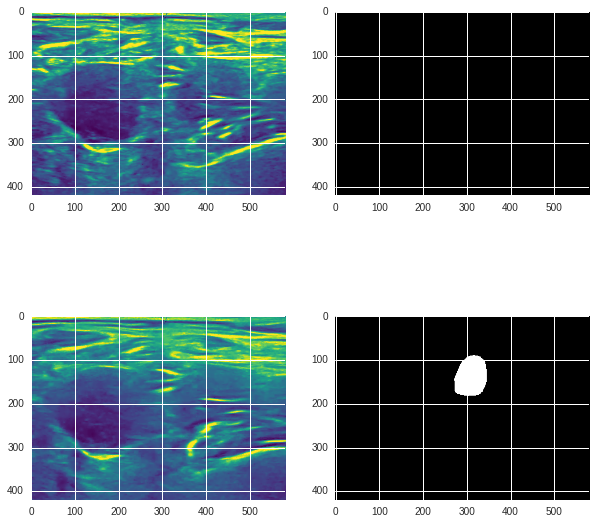

In [23]:
i = random.choice(list(conflicting.keys()))
j = random.choice(conflicting[i])
print('{} ({}), {} ({})'.format(i, train_files_map[keys_sorted[i]]['img_file'], 
                                j, train_files_map[keys_sorted[j]]['img_file']))

file_info_A = train_files_map[keys_sorted[i]]
file_info_B = train_files_map[keys_sorted[j]]
img_filepath_A = os.path.join(file_info_A['folder'], file_info_A['img_file'])
mask_filepath_A = os.path.join(file_info_A['folder'], file_info_A['mask_file'])
img_filepath_B = os.path.join(file_info_B['folder'], file_info_B['img_file'])
mask_filepath_B = os.path.join(file_info_B['folder'], file_info_B['mask_file'])
image_A = io.imread(img_filepath_A)
mask_A = io.imread(mask_filepath_A)
image_B = io.imread(img_filepath_B)
mask_B = io.imread(mask_filepath_B)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(image_A, cmap=plt.cm.viridis)
plt.subplot(2,2,2)
plt.imshow(mask_A, cmap=plt.cm.bone)
plt.subplot(2,2,3)
plt.imshow(image_B, cmap=plt.cm.viridis)
plt.subplot(2,2,4)
plt.imshow(mask_B, cmap=plt.cm.bone)

## save file info objects

In [18]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'wb') as f:
    pickle.dump(train_files_map, f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'wb') as f:
    pickle.dump(test_files_map, f)

In [24]:
with open(os.path.join(PROCDIR, 'conflicting_17.pkl'), 'wb') as f:
    pickle.dump(conflicting, f)